# Explainable machine learning for project control

# Backward analysis

In [1]:
import pandas as pd
import numpy as np
import pickle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [25]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

In [26]:
# random seed
seed=1123

In [2]:
#!pip install -q shap

In [3]:
import shap
import matplotlib.pyplot as plt
print('SHAP version:',shap.__version__)

SHAP version: 0.39.0


In [4]:
# Load JS (requiered for showing plots)
shap.initjs()

## Monte-Carlo simulation dataset
A case study based on Lambrechts (2008)

<img src='https://drive.google.com/uc?id=1-bCEgplDUqbRSO0NW7stGbLa9xI3DX81' width="400" align="left"/>
<img src='https://drive.google.com/uc?id=1JLt90ba0QGqV8yKzDu0-T-yZTB9-u0lW' width="500" align="left"/>

In [5]:
# Simulation  dataset
# Null model (5-rand) of comparison
dfsim_5_rand=pd.read_csv('./data/simulation_EV0.75_5-rand.csv',index_col=0)
dfsim_5_rand['critical_path']=dfsim_5_rand['critical_path'].astype('str')
# Interaction between activities 2-5
dfsim_2_5=pd.read_csv('./data/simulation_EV0.75_2-5.csv',index_col=0)
dfsim_2_5['critical_path']=dfsim_2_5['critical_path'].astype('str')

### Study point

In [6]:
# Chose a point where A2 tirggers the change in the A5 normal distribution
# Random instance with A5's duration greater than the threshold
# th=18-2*np.sqrt(0.83) # threshold
# sp_j=dfsim_2_5[dfsim_2_5['duration5']>th].sample(1).index[0]
# sp_j=28656
# study_point=dfsim_2_5.loc[sp_j,:].to_frame().T
# study_point.to_csv('./data/study_point.csv')
study_point=pd.read_csv('./data/study_point.csv',index_col=0)
study_point

,duration1,duration2,duration3,duration4,duration5,duration6,duration7,duration8,duration@1,duration@2,...,duration@4,duration@5,duration@6,duration@7,duration@8,cost@,duration@,cost,duration,critical_path
28656,1.589067,5.167076,7.719155,2.89666,17.757242,3.895929,9.127317,2.517356,1.589067,5.167076,...,2.89666,4.51667,1.964591,5.198019,0.0,20770.922395,9.683746,27702.749577,22.924318,259


## DBAC regression
DBAC~ {activity i's duration at 75%EV} i=1,...,8

### Gradient Boosting Regressor


In [353]:
# Regression models for dbac (1)
mdR_dbac={'5-rand':GradientBoostingRegressor(max_depth=3, n_estimators=100,random_state=seed),
     '2-5':GradientBoostingRegressor(max_depth=3, n_estimators=100,random_state=seed)}

In [10]:
# Regression models for dbac (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  # regression ouput and input variables
  y=data.loc[:,'duration']
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  # Train the model
  mdR_dbac[simulation].fit(X,y)
  print('MSE(%s): %0.4f' % (simulation,mean_squared_error(y,mdR_dbac[simulation].predict(X))))

MSE(5-rand): 8.9841
MSE(2-5): 0.7200


In [11]:
# Save models
for simulation in ['5-rand','2-5']:
  pickle.dump(mdR_dbac[simulation], open('./data/mdr_backward_dbac_' + simulation + '.pkl', 'wb'))

In [354]:
# Load models
for simulation in ['5-rand','2-5']:
  mdR_dbac[simulation]=pickle.load(open('./data/mdr_backward_dbac_' + simulation + '.pkl', 'rb'))

### Shapley values

In [13]:
# Shapley values (1)
shap_values_dbac=dict()
explainer_dbac=dict()

In [15]:
# Shapley values (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  X=study_point.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  explainer_dbac.update({simulation:shap.Explainer(mdR_dbac[simulation])})
  shap_values_dbac.update({simulation:explainer_dbac[simulation](X)})
  shap_values_dbac[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]

In [16]:
# save
for simulation in ['5-rand','2-5']:
  pickle.dump(explainer_dbac[simulation], open('./data/explainer_backward_dbac_' + simulation + '.pkl', 'wb'))
  pickle.dump(shap_values_dbac[simulation], open('./data/shap_values_backward_dbac_' + simulation + '.pkl', 'wb'))

In [17]:
# load
for simulation in ['5-rand','2-5']:
  explainer_dbac[simulation]=pickle.load(open('./data/explainer_backward_dbac_' + simulation + '.pkl', 'rb'))
  shap_values_dbac[simulation]=pickle.load(open('./data/shap_values_backward_dbac_' + simulation + '.pkl', 'rb'))

### Shapley plots

Null model (5-rand) of comparison


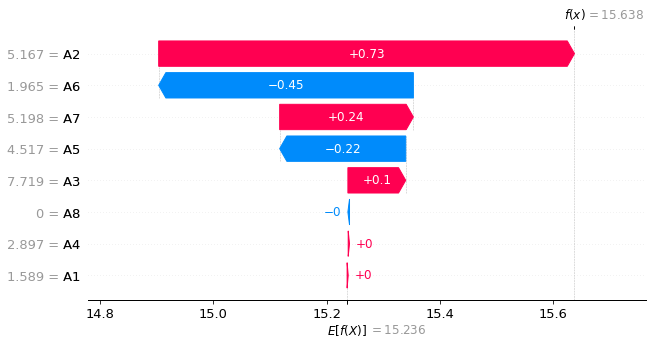

In [19]:
# watterfall plot
print('Null model (5-rand) of comparison')
simulation='5-rand'
# model
shapval=shap_values_dbac[simulation]
#shap.plots.waterfall(explainer2.expected_value, shap_values2.values[i,:])
# There is a bug in the current version with waterfall plot 
# (see https://github.com/slundberg/shap/issues/1420)
n=0
shap_object = shap.Explanation(base_values=shapval.base_values[n][0],
        values = shapval.values[n],
        feature_names = shapval.feature_names,
        data = shapval.data[n])
shap.plots.waterfall(shap_object,show=False)
plt.gcf().set_size_inches(10, 5)
plt.savefig('./figures/backward_waterfall_dbac_'+simulation +'.pdf')

Conditional interaction between activities 2-5


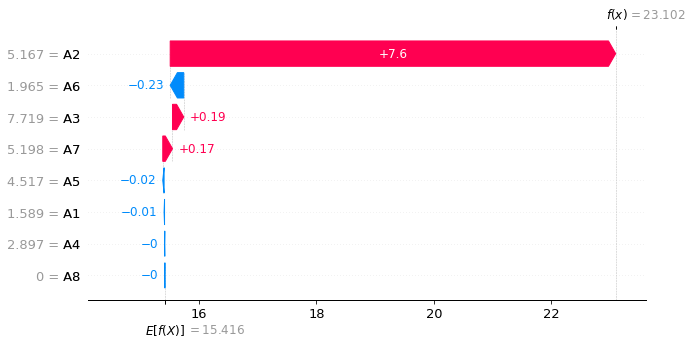

In [20]:
# watterfall plot
print('Conditional interaction between activities 2-5')
simulation='2-5'
# model
shapval=shap_values_dbac[simulation]
#shap.plots.waterfall(explainer2.expected_value, shap_values2.values[i,:])
# There is a bug in the current version with waterfall plot 
# (see https://github.com/slundberg/shap/issues/1420)
n=0
shap_object = shap.Explanation(base_values=shapval.base_values[n][0],
        values = shapval.values[n],
        feature_names = shapval.feature_names,
        data = shapval.data[n])
shap.plots.waterfall(shap_object,show=False)
plt.gcf().set_size_inches(10, 5)
plt.savefig('./figures/backward_waterfall_dbac_'+simulation +'.pdf')

## TB regression
TB~ {activity i's duration at 75%EV} i=1,...,8

### Gradient Boosting Regressor


In [27]:
# Regression models for tb (1)
mdR_tb={'5-rand':GradientBoostingRegressor(max_depth=5, n_estimators=1000,random_state=seed),
     '2-5':GradientBoostingRegressor(max_depth=5, n_estimators=1000,random_state=seed)}

In [28]:
# Regression models for tb (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  # regression ouput and input variables
  y=data.loc[:,'duration@']
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  # Train the model
  mdR_tb[simulation].fit(X,y)
  print('MSE(%s): %0.4f' % (simulation,mean_squared_error(y,mdR_tb[simulation].predict(X))))

MSE(5-rand): 0.0002
MSE(2-5): 0.0002


In [29]:
# Save models
for simulation in ['5-rand','2-5']:
  pickle.dump(mdR_tb[simulation], open('./data/mdr_backward_tb_' + simulation + '.pkl', 'wb'))

In [39]:
# Load models
for simulation in ['5-rand','2-5']:
  mdR_tb[simulation]=pickle.load(open('./data/mdr_backward_tb_' + simulation + '.pkl', 'rb'))

### Shapley values

In [31]:
# Shapley values (1)
shap_values_tb=dict()
explainer_tb=dict()

In [32]:
# Shapley values (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  X=study_point.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  explainer_tb.update({simulation:shap.Explainer(mdR_tb[simulation])})
  shap_values_tb.update({simulation:explainer_tb[simulation](X)})
  shap_values_tb[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]

In [33]:
# save
for simulation in ['5-rand','2-5']:
  pickle.dump(explainer_tb[simulation], open('./data/explainer_backward_tb_' + simulation + '.pkl', 'wb'))
  pickle.dump(shap_values_tb[simulation], open('./data/shap_values_backward_tb_' + simulation + '.pkl', 'wb'))

In [34]:
# load
for simulation in ['5-rand','2-5']:
  explainer_tb[simulation]=pickle.load(open('./data/explainer_backward_tb_' + simulation + '.pkl', 'rb'))
  shap_values_tb[simulation]=pickle.load(open('./data/shap_values_backward_tb_' + simulation + '.pkl', 'rb'))

### Shapley plots

Null model (5-rand) of comparison


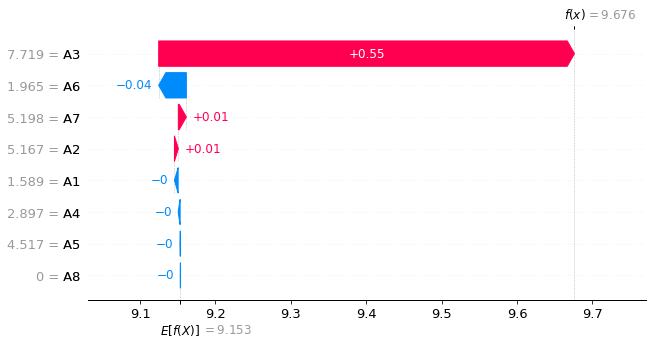

In [35]:
# watterfall plot
print('Null model (5-rand) of comparison')
simulation='5-rand'
# model
shapval=shap_values_tb[simulation]
#shap.plots.waterfall(explainer2.expected_value, shap_values2.values[i,:])
# There is a bug in the current version with waterfall plot 
# (see https://github.com/slundberg/shap/issues/1420)
n=0
shap_object = shap.Explanation(base_values=shapval.base_values[n][0],
        values = shapval.values[n],
        feature_names = shapval.feature_names,
        data = shapval.data[n])
shap.plots.waterfall(shap_object,show=False)
plt.gcf().set_size_inches(10, 5)
plt.savefig('./figures/backward_waterfall_tb_'+simulation +'.pdf')

Conditional interaction between activities 2-5


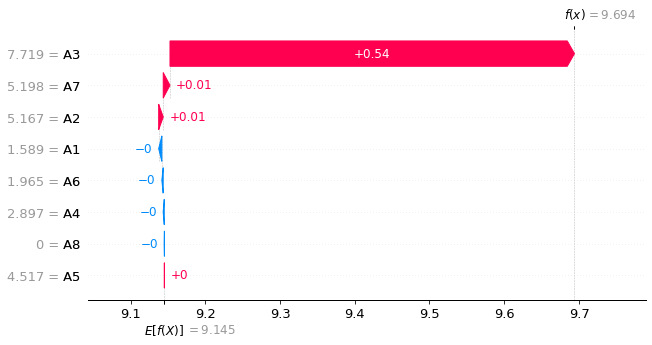

In [36]:
# watterfall plot
print('Conditional interaction between activities 2-5')
simulation='2-5'
# model
shapval=shap_values_tb[simulation]
#shap.plots.waterfall(explainer2.expected_value, shap_values2.values[i,:])
# There is a bug in the current version with waterfall plot 
# (see https://github.com/slundberg/shap/issues/1420)
n=0
shap_object = shap.Explanation(base_values=shapval.base_values[n][0],
        values = shapval.values[n],
        feature_names = shapval.feature_names,
        data = shapval.data[n])
shap.plots.waterfall(shap_object,show=False)
plt.gcf().set_size_inches(10, 5)
plt.savefig('./figures/backward_waterfall_tb_'+simulation +'.pdf')

## DBAC classification
DBACdelay~ {activity i's duration at 75%EV} i=1,...,8

In [37]:
# Classes 
# Expected time of the project 13
dfsim_2_5['delay']=dfsim_2_5['duration']>13
dfsim_5_rand['delay']=dfsim_5_rand['duration']>13

### Gradient Boosting Classifier

In [357]:
# Classifier models for dbac (1)
mdC_dbac={'5-rand':GradientBoostingClassifier(max_depth=5, n_estimators=100,random_state=seed),
     '2-5':GradientBoostingClassifier(max_depth=5, n_estimators=100,random_state=seed)}

In [42]:
# Classifier models for dbac (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  # ouput and input variables
  y=data.loc[:,'delay']
  X=data.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  # Train the model
  mdC_dbac[simulation].fit(X,y)
  print('Accuracy(%s): %0.4f' % (simulation,accuracy_score(y,mdC_dbac[simulation].predict(X))))

Accuracy(5-rand): 0.8713
Accuracy(2-5): 0.9020


In [43]:
# Save models
for simulation in ['5-rand','2-5']:
  pickle.dump(mdC_dbac[simulation], open('./data/mdc_backward_C_dbac_' + simulation + '.pkl', 'wb'))

In [358]:
# Load models
for simulation in ['5-rand','2-5']:
  mdC_dbac[simulation]=pickle.load(open('./data/mdc_backward_C_dbac_' + simulation + '.pkl', 'rb'))

### Shapley values

In [359]:
# Shapley values (1)
shap_values_C_dbac=dict()
explainer_C_dbac=dict()

In [46]:
# Shapley values (2)
for (simulation, data) in [('5-rand',dfsim_5_rand),('2-5',dfsim_2_5)]:
  X=study_point.loc[:,['duration@1','duration@2', 'duration@3','duration@4', 'duration@5','duration@6', 'duration@7','duration@8']]
  explainer_C_dbac.update({simulation:shap.Explainer(mdC_dbac[simulation])})
  shap_values_C_dbac.update({simulation:explainer_C_dbac[simulation](X)})
  shap_values_C_dbac[simulation].feature_names=[ 'A'+str(i) for i in range(1,9)]

In [49]:
# save
for simulation in ['5-rand','2-5']:
  pickle.dump(explainer_C_dbac[simulation], open('./data/explainer_backward_C_dbac_' + simulation + '.pkl', 'wb'))
  pickle.dump(shap_values_C_dbac[simulation], open('./data/shap_values_backward_C_dbac_' + simulation + '.pkl', 'wb'))

In [360]:
# load
for simulation in ['5-rand','2-5']:
  explainer_C_dbac[simulation]=pickle.load(open('./data/explainer_backward_C_dbac_' + simulation + '.pkl', 'rb'))
  shap_values_C_dbac[simulation]=pickle.load(open('./data/shap_values_backward_C_dbac_' + simulation + '.pkl', 'rb'))

### Shapley plots

Null model (5-rand) of comparison


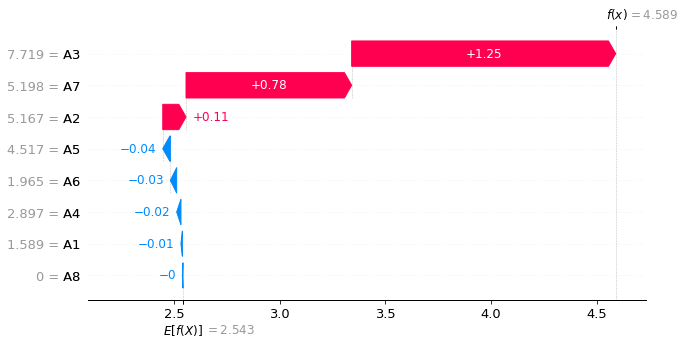

In [361]:
# watterfall plot
print('Null model (5-rand) of comparison')
simulation='5-rand'
# model
shapval=shap_values_C_dbac[simulation]
#shap.plots.waterfall(explainer2.expected_value, shap_values2.values[i,:])
# There is a bug in the current version with waterfall plot 
# (see https://github.com/slundberg/shap/issues/1420)
n=0
shap_object = shap.Explanation(base_values=shapval.base_values[n][0],
        values = shapval.values[n],
        feature_names = shapval.feature_names,
        data = shapval.data[n])
shap.plots.waterfall(shap_object,show=False)
plt.gcf().set_size_inches(10, 5)
plt.savefig('./figures/backward_waterfall_C_dbac_'+simulation +'_logodd.pdf')

In [371]:
# force plot
print('Null model (5-rand) of comparison')
simulation='5-rand'
# model
shapval=shap_values_C_dbac[simulation]
n=0
shap.force_plot(base_value=shapval.base_values[n][0],
                shap_values=shapval.values[n],
                feature_names=shapval.feature_names,
                #matplotlib=True,
                link="logit")

Null model (5-rand) of comparison


## REMOVE THAT !!!!!!!!!!!

In [212]:
# Nacho v0.1

In [213]:
# form log(odds) to probability and viceversa
def p2logodd(p):
    return np.log(p/(1-p))
def logodd2p(lodd):
    return np.exp(lodd)/(1+np.exp(lodd))

In [268]:
# load
for simulation in ['5-rand','2-5']:
  explainer_C_dbac[simulation]=pickle.load(open('./data/explainer_backward_C_dbac_' + simulation + '.pkl', 'rb'))
  shap_values_C_dbac[simulation]=pickle.load(open('./data/shap_values_backward_C_dbac_' + simulation + '.pkl', 'rb'))

Null model (5-rand) of comparison


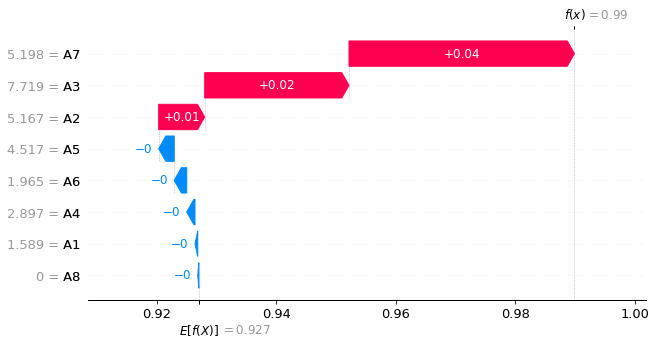

In [271]:
print('Null model (5-rand) of comparison')
simulation='5-rand'
# model
shapval=shap_values_C_dbac[simulation]

# Transform log(odds) to probabilities for waterfall plot
lsv=[('A'+str(i+1),shapval.values[0][i]) for i in range(8)]
lsv=sorted(lsv,key=lambda x: np.abs(x[1]))
l0=shapval.base_values[0][0]
dfsv=pd.DataFrame(lsv,columns=['activity','shap'])


dfsv['shap_cum']=dfsv['shap'].cumsum()
dfsv['lodd_prob_cum']=dfsv['shap_cum']+l0
dfsv['prob_cum']=dfsv['lodd_prob_cum'].apply(logodd2p)
dfsv['prob_marg']=np.concatenate(([dfsv.loc[0,'prob_cum']-logodd2p(l0)],
                                    dfsv.loc[1:,'prob_cum'].values - dfsv.loc[:6,'prob_cum'].values),axis=None)
dfsv.sort_values(by='activity',inplace=True)
# dfsv['prob_marg'].sum()+logodd2p(l0) # check

shapval.values[0]=dfsv['prob_marg'].values
shapval.base_values[0][0]=logodd2p(l0)
shap_object = shap.Explanation(base_values=shapval.base_values[0][0],
        values = shapval.values[0],
        feature_names = shapval.feature_names,
        data = shapval.data[0])
shap.plots.waterfall(shap_object,show=False)
plt.gcf().set_size_inches(10, 5)
#plt.savefig('./figures/backward_waterfall_C_dbac_'+simulation +'_prob.pdf')

In [294]:
dfsv.sort_values(by='shap',key=lambda x: np.abs(x),inplace=True)
dfsv['data']=0
for i in range(len(shapval.feature_names)):
    dfsv.loc[dfsv['activity']==shapval.feature_names[i],'data']=shapval.data[0][i]
dfsv

,activity,shap,shap_cum,lodd_prob_cum,prob_cum,prob_marg,data
0,A8,-0.002658,-0.002658,2.539930,0.926894,-0.000180,0.000000
1,A1,-0.006824,-0.009482,2.533107,0.926430,-0.000464,1.589067
2,A4,-0.020180,-0.029662,2.512926,0.925043,-0.001387,2.896660
3,A6,-0.029805,-0.059468,2.483121,0.922950,-0.002093,1.964591
4,A5,-0.035995,-0.095463,2.447126,0.920351,-0.002599,4.516670
5,A2,0.110007,0.014544,2.557133,0.928051,0.007700,5.167076
6,A7,0.783170,0.797713,3.340302,0.965786,0.037735,5.198019
7,A3,1.248515,2.046228,4.588817,0.989937,0.024152,7.719155


In [372]:
# test

In [96]:
# expected value
print('expected value')
print(shapval.base_values[0][0], logodd2p(shapval.base_values[0][0]))
# prediction
print('prediction')
print(p2logodd(mdC_dbac[simulation].predict_proba(X)[0][1]),mdC_dbac[simulation].predict_proba(X)[0][1])
# sum of shapley values to expected value
print('sum of Shapley values to expected value')
print(shapval.values[0].sum() + shapval.base_values[0][0], logodd2p(shapval.values[0].sum() + shapval.base_values[0][0]))

expected value
2.5425887420797455 0.9270740392583532
prediction
4.588816780727936 0.9899374064998275
sum of Shapley values to expected value
4.588816780727939 0.9899374064998275
